In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd
import glob

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(directory = 'Group_8/train/',image_size=(224, 224))
val_dataset = tf.keras.utils.image_dataset_from_directory(directory = 'Group_8/val/',image_size=(224, 224))
test_dataset = tf.keras.utils.image_dataset_from_directory(directory = 'Group_8/test/',image_size=(224, 224))

Found 150 files belonging to 3 classes.
Found 30 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


In [5]:
X_train = np.concatenate([x for x, y in train_dataset], axis=0)/255
Y_train = np.concatenate([y for x, y in train_dataset], axis=0)

X_val = np.concatenate([x for x, y in val_dataset], axis=0)/255
Y_val = np.concatenate([y for x, y in val_dataset], axis=0)

X_test = np.concatenate([x for x, y in test_dataset], axis=0)/255
Y_test = np.concatenate([y for x, y in test_dataset], axis=0)

In [6]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

augmenter = data_augmenter()

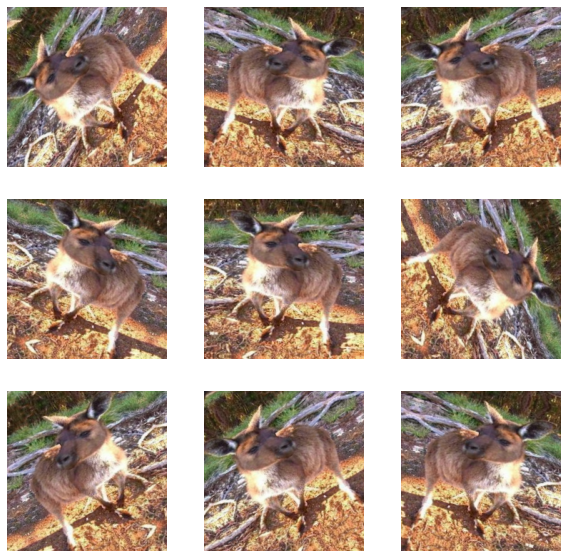

In [10]:
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
first_image = X_train[0]
for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] )
        plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
def modify_base_model(input_shape, data_augmentation = data_augmenter()):
    
    ### START CODE HERE
    
    #base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
#                                                    include_top=False, 
#                                                    weights='imagenet') 
    
    base_model=tf.keras.applications.vgg19.VGG19(
                            include_top=False,
                            weights='imagenet'
                        )

    
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape) 
    
    x = data_augmentation(inputs)
    x = preprocess_input(x) 
    
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dropout(rate = 0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(3)(x)
    outputs = tf.keras.layers.Softmax()(outputs)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [25]:
model2 = modify_base_model(X_train[0].shape, data_augmentation)

In [26]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0     

In [27]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
initial_epochs = 5
history = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=initial_epochs)

Epoch 1/5
5/5 [==============================] - 33s 7s/step - loss: 1.1050 - accuracy: 0.3267 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 2/5
5/5 [==============================] - 34s 7s/step - loss: 1.0979 - accuracy: 0.3067 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 3/5
5/5 [==============================] - 34s 7s/step - loss: 1.0997 - accuracy: 0.3133 - val_loss: 1.1000 - val_accuracy: 0.3333
Epoch 4/5
5/5 [==============================] - 35s 7s/step - loss: 1.0997 - accuracy: 0.3733 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 5/5
5/5 [==============================] - 35s 7s/step - loss: 1.1008 - accuracy: 0.3400 - val_loss: 1.0994 - val_accuracy: 0.3333


In [ ]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
fine_tune_epochs = 5
# total_epochs =  initial_epochs + fine_tune_epochs
total_epochs =  20

history_fine = model2.fit(X_train, Y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val, Y_val))